### Install Required Libraries

In [2]:
!pip install pydicom numpy matplotlib opencv-python

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 26.0 MB/s eta 0:00:00


### Load and Visualize DICOM File

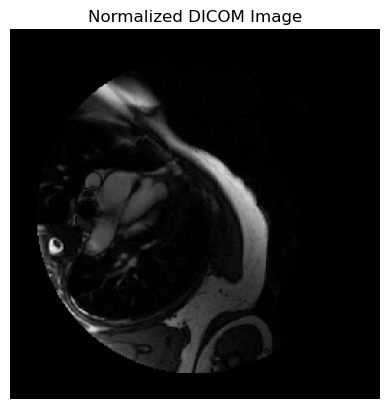

In [31]:
import cv2
import pydicom
import numpy as np
import matplotlib.pyplot as plt

# Load the DICOM file
dicom_path = "SCD_IMAGES_01/SCD0000101/CINELAX_301/IM-0004-0001.dcm"
dicom_data = pydicom.dcmread(dicom_path)

# Convert pixel data to NumPy array
image_array = dicom_data.pixel_array.astype(np.float32)

# Normalize to [0, 255]
image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array)) * 255
image_array = image_array.astype(np.uint8)

# Display the normalized image
plt.imshow(image_array, cmap="gray")
plt.title("Normalized DICOM Image")
plt.axis("off")
plt.show()

In [32]:
# Extract metadata from DICOM file
print(f"Patient ID: {dicom_data.PatientID}")
print(f"Modality: {dicom_data.Modality}")
print(f"Study Date: {dicom_data.StudyDate}")
print(f"Image Dimensions: {image_array.shape}")

Patient ID: SCD0000101
Modality: MR
Study Date: 20120000
Image Dimensions: (256, 256)


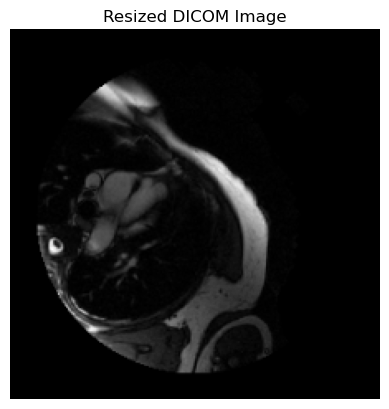

'To prepare for deep learning, ensure all images are of a fixed size (e.g., 224x224).'

In [30]:
# Normalize image pixel values to range [0, 1]
normalized_image = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))

import cv2

# Resize image to 224x224
resized_image = cv2.resize(normalized_image, (224, 224))
plt.imshow(resized_image, cmap="gray")
plt.title("Resized DICOM Image")
plt.axis("off")
plt.show()

"""To prepare for deep learning, ensure all images are of a fixed size (e.g., 224x224)."""

## Enhanced Image

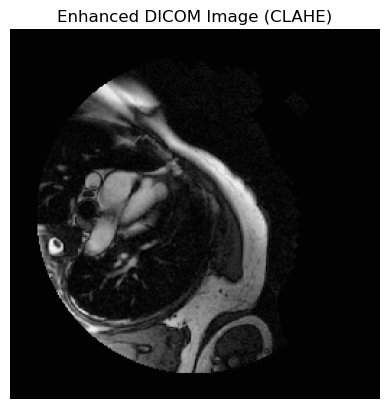

In [33]:
import cv2
import pydicom
import numpy as np
import matplotlib.pyplot as plt

# Load the DICOM file
dicom_path = "SCD_IMAGES_01/SCD0000101/CINELAX_301/IM-0004-0001.dcm"
dicom_data = pydicom.dcmread(dicom_path)

# Convert pixel data to NumPy array (float32)
image_array = dicom_data.pixel_array.astype(np.float32)

# Normalize image to range 0-255 and convert to uint8
image_array = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array)) * 255
image_array = image_array.astype(np.uint8)

# Apply CLAHE
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
enhanced_image = clahe.apply(image_array)

# Display the enhanced image
plt.imshow(enhanced_image, cmap="gray")
plt.title("Enhanced DICOM Image (CLAHE)")
plt.axis("off")
plt.show()

In [12]:
import os
import pydicom
import numpy as np
import cv2

# Define input and output paths
input_dir = "SCD_IMAGES_01"  # Root folder with all patient subdirectories
output_dir = "Processed_Images"  # Folder to store processed images
os.makedirs(output_dir, exist_ok=True)

# Loop through all patient folders
for patient_folder in os.listdir(input_dir):
    patient_path = os.path.join(input_dir, patient_folder)

    # Ensure it's a directory, not a file like `.DS_Store`
    if not os.path.isdir(patient_path):
        continue  # Skip non-directories

    # Loop through subdirectories (CINELAX, PERF, etc.)
    for scan_folder in os.listdir(patient_path):
        scan_path = os.path.join(patient_path, scan_folder)

        # Ensure it's a directory
        if not os.path.isdir(scan_path):
            continue

        # Create output subfolder
        output_subfolder = os.path.join(output_dir, f"{patient_folder}_{scan_folder}")
        os.makedirs(output_subfolder, exist_ok=True)

        # Process each DICOM file in the subfolder
        for filename in os.listdir(scan_path):
            if filename.endswith(".dcm"):
                dicom_path = os.path.join(scan_path, filename)
                dicom_data = pydicom.dcmread(dicom_path)

                # Extract and preprocess
                image_array = dicom_data.pixel_array
                normalized_image = (image_array - np.min(image_array)) / (np.max(image_array) - np.min(image_array))
                resized_image = cv2.resize(normalized_image, (224, 224))

                # Save as PNG
                output_path = os.path.join(output_subfolder, filename.replace(".dcm", ".png"))
                cv2.imwrite(output_path, (resized_image * 255).astype(np.uint8))

print("Processing complete! All images are saved in:", output_dir)

Processing complete! All images are saved in: Processed_Images


before jumping into modeling, let's analyze the dataset.

Visualize sample images

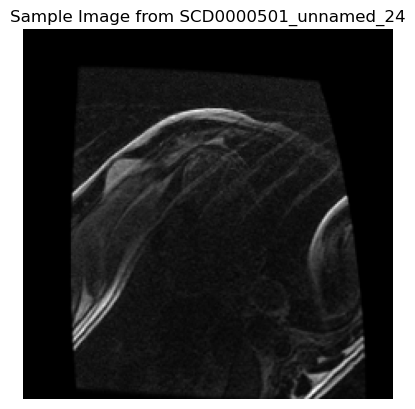

In [13]:
import os
import matplotlib.pyplot as plt
import cv2
import random

processed_dir = "Processed_Images"

# Get all folders
folders = os.listdir(processed_dir)

# Pick a random folder and image
random_folder = random.choice(folders)
folder_path = os.path.join(processed_dir, random_folder)
random_image = random.choice(os.listdir(folder_path))
image_path = os.path.join(folder_path, random_image)

# Load and display
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
plt.imshow(image, cmap="gray")
plt.title(f"Sample Image from {random_folder}")
plt.axis("off")
plt.show()

In [14]:
import numpy as np
from sklearn.model_selection import train_test_split

data = []
labels = []

# Read all processed images
for folder in os.listdir(processed_dir):
    folder_path = os.path.join(processed_dir, folder)
    
    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
        img = img / 255.0  # Normalize
        
        data.append(img)
        labels.append(folder)  # Assuming folder names represent classes

# Convert to numpy
data = np.array(data)
labels = np.array(labels)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

print("Dataset Ready: ", X_train.shape, X_test.shape)

Dataset Ready:  (7315, 224, 224) (1829, 224, 224)


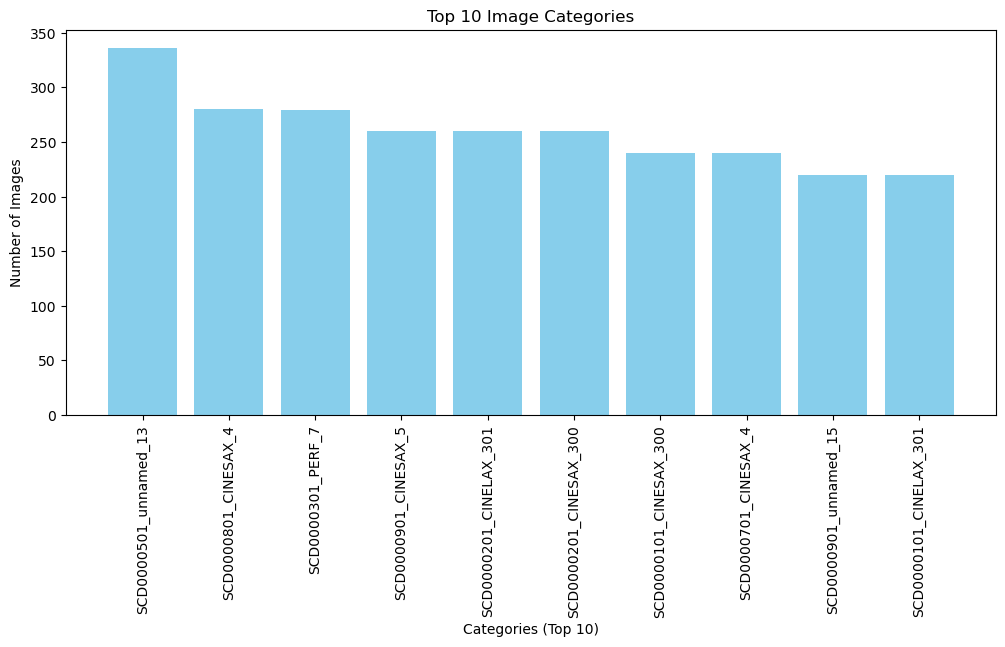

In [20]:
import matplotlib.pyplot as plt

# Sort categories by image count
sorted_counts = dict(sorted(class_counts.items(), key=lambda item: item[1], reverse=True))

# Select top 10 classes
top_n = 10
top_classes = list(sorted_counts.keys())[:top_n]
top_values = list(sorted_counts.values())[:top_n]

# Plot the top categories
plt.figure(figsize=(12, 5))
plt.bar(top_classes, top_values, color='skyblue')
plt.xlabel("Categories (Top 10)")
plt.ylabel("Number of Images")
plt.title("Top 10 Image Categories")
plt.xticks(rotation=90)
plt.show()